# Import Packages

In [48]:
import os
import pickle as pkl
import sys
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define variables (used across the code)

In [49]:
# Define unique colors
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

### configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

# Define Utility Functions

In [50]:
def add_colored_label(ax, x, y, bgcolor, width=1, height=1):
  rect = Rectangle((x, y), width, height, facecolor=bgcolor)
  ax.add_patch(rect)
  
def show_heatmaps(vmin_val, vmax_val, matrices, titles, cbar_label=None, color_labels=None):
    num_plots = len(matrices)
    fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

    if num_plots == 1:
        axs = [axs]

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axs[i]
        
        im = ax.imshow(matrix, aspect='auto', vmin=vmin_val, vmax=vmax_val)
        ax.set_title(title)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(cbar_label)

        # Adjust the height of the color bar
        position = cax.get_position()
        new_position = [position.x0, position.y0 + 0.1, position.width, position.height * 0.8]
        cax.set_position(new_position)

        if color_labels is not None:
            ax.axis('off')
            for idx, color in enumerate(color_labels):
                add_colored_label(ax, -1.5, idx-0.5, color, width=0.8)
                add_colored_label(ax, idx-0.5, matrix.shape[1] - 0.2, color, height=0.8)

            ax.set_aspect('equal')
            ax.set_xlim(-3.0, matrix.shape[1])
            ax.set_ylim(-1, len(color_labels)+1.4)
            ax.invert_yaxis()

            for spine in ax.spines.values():
                spine.set_visible(False)

    plt.tight_layout()
    plt.show()

def transform_value(value):
    return -value + 3.5

def RSA(matrix1, matrix2, method='pearson'):
  upper_tri_1 = matrix1[np.triu_indices(matrix1.shape[0], k=1)]
  upper_tri_2 = matrix2[np.triu_indices(matrix2.shape[0], k=1)]
  if method == 'pearson':
    corr, _ = pearsonr(upper_tri_1, upper_tri_2)
  elif method == 'spearman':
    corr, _ = spearmanr(upper_tri_1, upper_tri_2)

  return corr

def comp_matching_rate(OT_plan, k, order="maximum"):
  # This function computes the matching rate, assuming that in the optimal transportation plan,
  # the items in the i-th row and the j-th column are the same (correct mactch) when i = j.
  # Thus, the diagonal elements of the optimal transportation plan represent the probabilities
  # that the same items (colors) match between the two structures.

  # Get the diagonal elements
  diagonal = np.diag(OT_plan)
  # Get the top k values for each row
  if order == "maximum":
      topk_values = np.partition(OT_plan, -k)[:, -k:]
  elif order == "minimum":
      topk_values = np.partition(OT_plan, k - 1)[:, :k]
  # Count the number of rows where the diagonal is in the top k values and compute the matching rate
  count = np.sum([diagonal[i] in topk_values[i] for i in range(OT_plan.shape[0])])
  matching_rate = count / OT_plan.shape[0] * 100
  return matching_rate

# Function to plot the embeddings
## Not used in this code
def plot_embeddings(embeddings, titles, color_labels, overlay=False):
    fig = go.Figure()
    
    if overlay:
        for i, embedding in enumerate(embeddings):
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center",
                name=titles[i]
            ))
    else:
        for i, embedding in enumerate(embeddings):
            fig = go.Figure()
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center"
            ))
            fig.update_layout(
                title=f'MDS Embedding - {titles[i]}',
                scene=dict(
                    xaxis_title='Dimension 1',
                    yaxis_title='Dimension 2',
                    zaxis_title='Dimension 3'
                ),
                height=800
            )
    fig.show()

# Define the function to compute minimum GWD for the range of epsilons
def compute_min_gwd(matrix_1, matrix_2, epsilons):

    OT_plans = []
    gwds = []
    matching_rates = []

    for epsilon in epsilons:
      OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=matrix_1, C2=matrix_2 , epsilon=epsilon, loss_fun="square_loss", log=True)  # optimization
      gwd = gw_log['gw_dist']
      matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
      OT_plans.append(OT)
      gwds.append(gwd)
      matching_rates.append(matching_rate)

    return min(gwds)

def GWD_and_plot(matrix1, matrix2, epsilons):
    
    OT_plans = []
    gwds = []
    matching_rates = []

    for epsilon in epsilons:
      OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=matrix1, C2=matrix2 , epsilon=epsilon, loss_fun="square_loss", log=True)  # optimization
      gwd = gw_log['gw_dist']
      matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
      OT_plans.append(OT)
      gwds.append(gwd)
      matching_rates.append(matching_rate)

      
    plt.scatter(epsilons, gwds, c=matching_rates)
    plt.xlabel("epsilon")
    plt.ylabel("GWD")
    plt.xscale('log')
    plt.grid(True, which = 'both')
    cbar = plt.colorbar()
    cbar.set_label(label='Matching Rate (%)')
    plt.show()

    # extract the best epsilon that minimizes the GWD
    min_gwd = min(gwds)
    best_eps_idx = gwds.index(min_gwd)
    best_eps = epsilons[best_eps_idx]
    OT_plan = OT_plans[best_eps_idx]
    matching_rate = matching_rates[best_eps_idx]

    show_heatmaps(0, 0.1, matrices=[OT_plan], titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'])

    return OT_plan, gwds, matching_rates


def OT_epsilon(epsilons, OT_plans, gwds, e_ind, matching_rates):

    best_eps_idx = e_ind
    min_gwd = gwds[best_eps_idx]
    best_eps = epsilons[best_eps_idx]
    OT_plan = OT_plans[best_eps_idx]
    matching_rate = matching_rates[best_eps_idx]

    show_heatmaps(0, 0.05,
        matrices=[OT_plan],
        titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'],
        color_labels=unique_colours)
    
# Define the function to shuffle the matrix
def shuffle_upper_triangular_and_asymmetritisize(matrix, size):
    matrix_copy = matrix.copy()
    # Set the diagonal elements to zero
    np.fill_diagonal(matrix_copy, 0)

    # Shuffle the upper triangular elements
    upper_tri_indices = np.triu_indices(size, 1)
    upper_tri_values = matrix_copy[upper_tri_indices].copy()
    np.random.shuffle(upper_tri_values)
    matrix_copy[upper_tri_indices] = upper_tri_values
    
    # Set the lower triangular part of the matrix to the negative of the upper triangular part
    for i in range(size):
        for j in range(i + 1, size):
            matrix_copy[j, i] = -matrix_copy[i, j]
    
    return matrix_copy

# Shuffle elements across rows except the diagonal elements
def shuffle_column_and_asymmetritisize(matrix, size):
    matrix_copy = matrix.copy()
    np.fill_diagonal(matrix_copy, 0)

    # Set the lower triangular part of the matrix to the negative of the upper triangular part
    for i in range(size):
        for j in range(i + 1, size):
            matrix_copy[j, i] = -matrix_copy[i, j]

    for i in range(size):
        non_diag_indices = [j for j in range(matrix_size) if j != i]
        non_diag_values = matrix_copy[non_diag_indices, i].copy()
        np.random.shuffle(non_diag_values)
        matrix_copy[non_diag_indices, i] = non_diag_values
    
    return matrix_copy

# Load Data

In [51]:
# Create matrix
matrix_1 = np.zeros((matrix_size, matrix_size))
matrix_2 = np.zeros((matrix_size, matrix_size))

# Load the second CSV file
df_PM1 = pd.read_csv('raw_data/color_preference_qualia/239485_mike_kana_colourPreferenceQualia_2024-09-26_10h56.02.764.csv')

# Extract columns
colour1_1 = df_PM1['colour1']
colour2_1 = df_PM1['colour2']
target_preference_1 = df_PM1['response']

# Fill the matrix
for c1, c2, tp in zip(colour1_1, colour2_1, target_preference_1):
    I = colour_index[c1]
    j = colour_index[c2]
    matrix_1[I, j] = tp

# Load the second CSV file
df_PM2 = pd.read_csv('raw_data/color_preference_qualia/721430_angus_kana_colourPreferenceQualia_2024-09-25_11h22.04.672.csv')

# Extract columns
colour1_2 = df_PM2['colour1']
colour2_2 = df_PM2['colour2']
target_preference_2 = df_PM2['response']

# Fill the matrix
for c1, c2, tp in zip(colour1_2, colour2_2, target_preference_2):
    I = colour_index[c1]
    j = colour_index[c2]
    matrix_2[I, j] = tp


# Raw Data - asymmetric

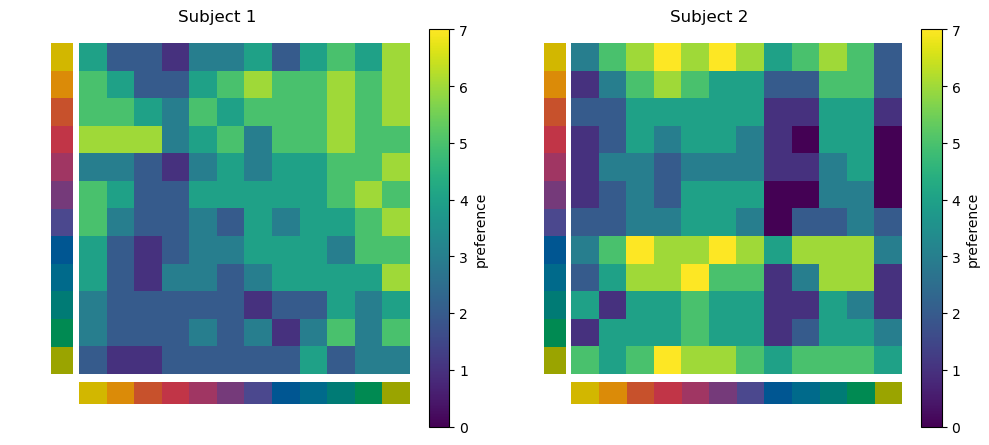

In [95]:
show_heatmaps(0, 7, matrices=[matrix_1, matrix_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# No Value Mapping - symmetric

In [99]:
# Get the size of the matrix (assume it's square)
n = matrix_1.shape[0]

# Create an empty matrix to store the symmetrical version
sym_matrix_1 = np.zeros_like(matrix_1)

# Loop through the upper triangle and the diagonal of the matrix
for i in range(n):
    for j in range(i, n):
        # Compute the average of the symmetric cells (i,j) and (j,i)
        avg_value = (matrix_1[i, j] + matrix_1[j, i]) / 2.0
        # Assign the average to both (i,j) and (j,i) in the new symmetrical matrix
        sym_matrix_1[i, j] = avg_value
        sym_matrix_1[j, i] = avg_value

# Set all diagonal elements to zero
np.fill_diagonal(sym_matrix_1, 0)

# Convert to DataFrame for better readability
sym_matrix_1_df = pd.DataFrame(sym_matrix_1, index=unique_colours, columns=unique_colours)

In [100]:
# Get the size of the matrix (assume it's square)
n = matrix_2.shape[0]

# Create an empty matrix to store the symmetrical version
sym_matrix_2 = np.zeros_like(matrix_2)

# Loop through the upper triangle and the diagonal of the matrix
for i in range(n):
    for j in range(i, n):
        # Compute the average of the symmetric cells (i,j) and (j,i)
        avg_value = (matrix_2[i, j] + matrix_2[j, i]) / 2.0
        # Assign the average to both (i,j) and (j,i) in the new symmetrical matrix
        sym_matrix_2[i, j] = avg_value
        sym_matrix_2[j, i] = avg_value

# Set all diagonal elements to zero
np.fill_diagonal(sym_matrix_2, 0)

# Convert to DataFrame for better readability
sym_matrix_2_df = pd.DataFrame(sym_matrix_2, index=unique_colours, columns=unique_colours)

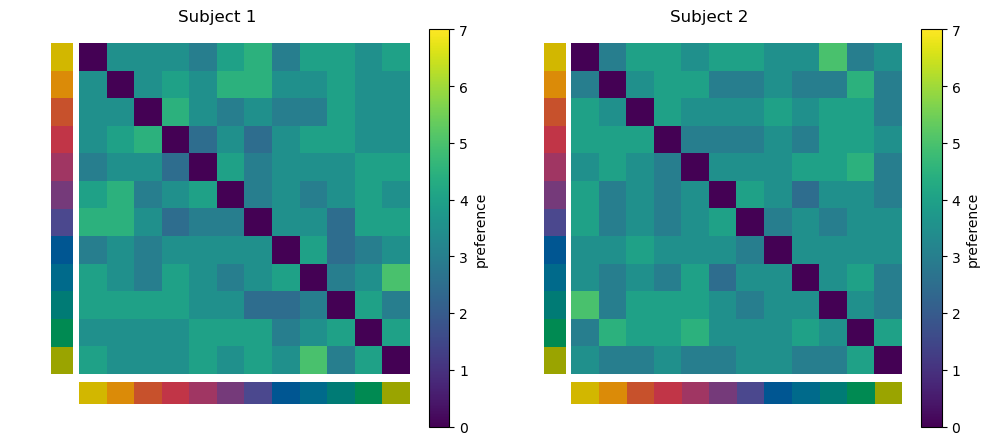

In [101]:
show_heatmaps( 0, 7, matrices=[sym_matrix_1, sym_matrix_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# Value Mapping to -3.5 ~ 3.5 - raw matrix

In [105]:
# Apply the transformation rule to the entire matrix
value_mapped_raw_1 = np.vectorize(transform_value)(matrix_1)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_raw_1, 0)

# Convert to DataFrame for better readability
value_mapped_raw_1_df = pd.DataFrame(value_mapped_raw_1, index=unique_colours, columns=unique_colours)

In [106]:
# Apply the transformation rule to the entire matrix
value_mapped_raw_2 = np.vectorize(transform_value)(matrix_2)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_raw_2, 0)

# Convert to DataFrame for better readability
value_mapped_raw_2_df = pd.DataFrame(value_mapped_raw_2, index=unique_colours, columns=unique_colours)

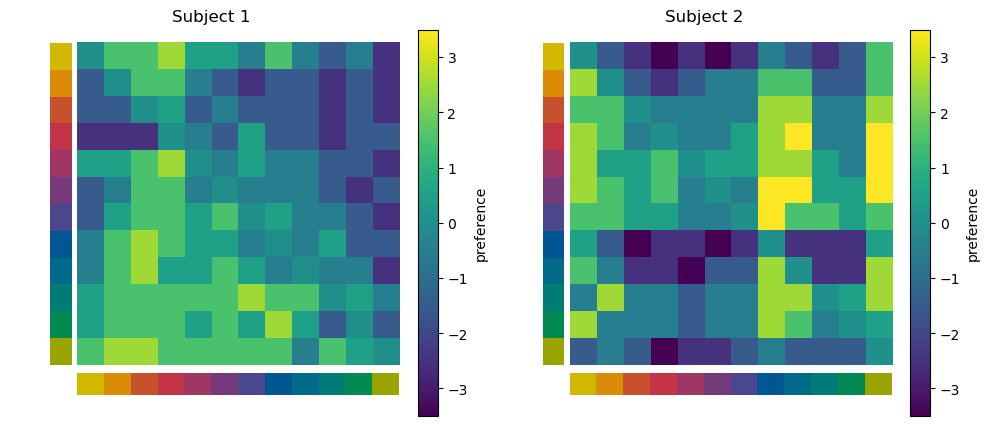

In [107]:
show_heatmaps(-3.5, 3.5, matrices=[value_mapped_raw_1, value_mapped_raw_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# Value Mapping to -3.5 ~ 3.5 - symetric matrix

In [112]:
# Apply the transformation rule to the entire matrix
value_mapped_sym_1 = np.vectorize(transform_value)(sym_matrix_1)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_sym_1, 0)

# Convert to DataFrame for better readability
value_mapped_sym_1_df = pd.DataFrame(value_mapped_sym_1, index=unique_colours, columns=unique_colours)

In [113]:
# Apply the transformation rule to the entire matrix
value_mapped_sym_2 = np.vectorize(transform_value)(sym_matrix_2)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_sym_2, 0)

# Convert to DataFrame for better readability
value_mapped_sym_2_df = pd.DataFrame(value_mapped_sym_2, index=unique_colours, columns=unique_colours)

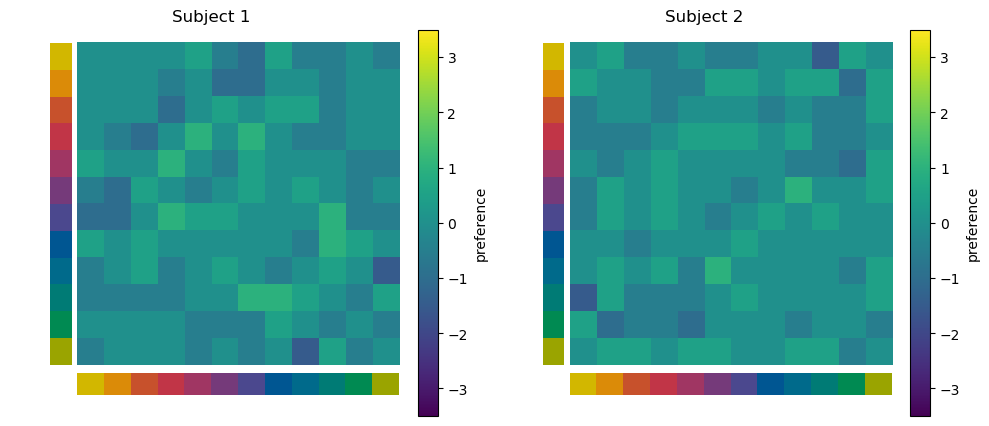

In [114]:
show_heatmaps(-3.5, 3.5, matrices=[value_mapped_sym_1, value_mapped_sym_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# MDS

### 1D MDS and overall preference rating

In [111]:
def plot_1DMDS_overallPreference(matrix_transformed_1, matrix_transformed_2, matrix_transformed_1_as, matrix_transformed_2_as, unique_colours):
    embeddings = []
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=1, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    row_averages_1 = matrix_transformed_1_as.mean(axis=0).reshape(-1, 1)
    embeddings_1 = np.hstack((embeddings[0], row_averages_1))

    row_averages_2 = matrix_transformed_2_as.mean(axis=0).reshape(-1, 1)
    embeddings_2 = np.hstack((embeddings[1], row_averages_2))

    embeddings_3 = [embeddings_1, embeddings_2]

    # Plot the embeddings
    plt.figure(figsize=(12, 6))

    # Plot the first embedding
    plt.subplot(1, 2, 1)
    plt.scatter(embeddings_3[0][:, 0], embeddings_3[0][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings_3[0][i, 0], embeddings_3[0][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 1')
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('Overall Preference value', fontsize=14)

    # Plot the second embedding
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings_3[1][:, 0], embeddings_3[1][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings_3[1][i, 0], embeddings_3[1][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 2')
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('Overall Preference value', fontsize=14)

    plt.tight_layout()
    plt.show()

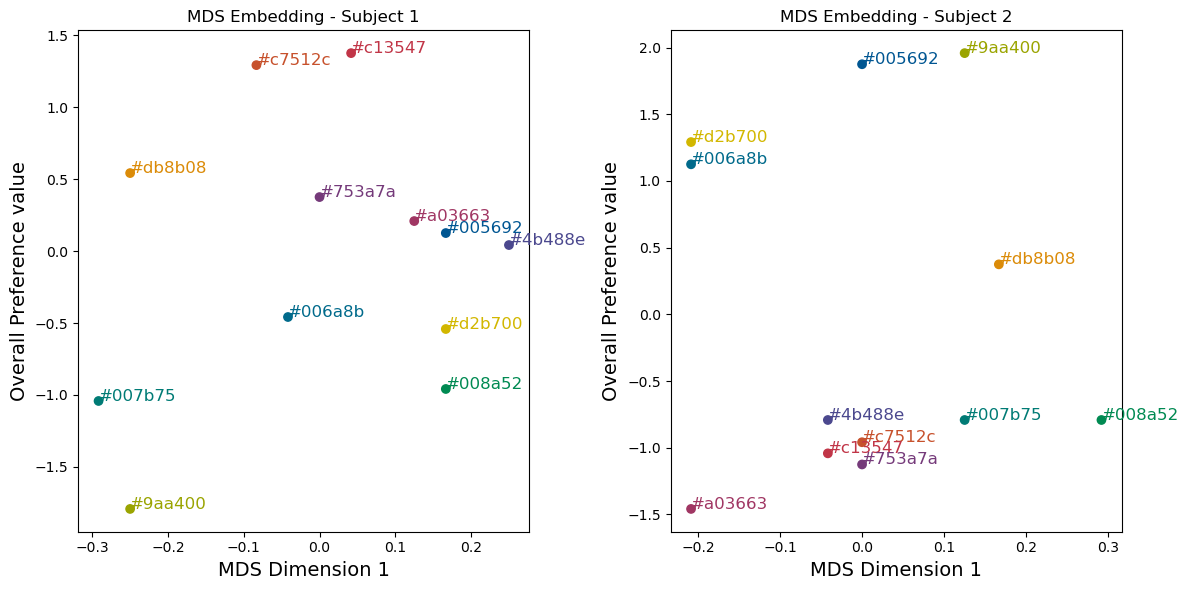

In [115]:
plot_1DMDS_overallPreference(value_mapped_sym_1, value_mapped_sym_2, value_mapped_raw_1, value_mapped_raw_2, unique_colours)

### 3D MDS

In [69]:
def plot_3D_embeddings(embeddings, titles, color_labels, overlay=False):

    if overlay:
        fig = go.Figure()
        for i, embedding in enumerate(embeddings):
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center",
                name=titles[i]
            ))
        fig.update_layout(
            title='Overlayed MDS Embeddings',
            scene=dict(
                xaxis_title='Dimension 1',
                yaxis_title='Dimension 2',
                zaxis_title='Dimension 3'
            ),
            height=800,
            plot_bgcolor='white'
        )
        fig.show()
    else:
        for i, embedding in enumerate(embeddings):
            fig = go.Figure()
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center"
            ))
            fig.update_layout(
                title=f'MDS Embedding - {titles[i]}',
                scene=dict(
                    xaxis_title='Dimension 1',
                    yaxis_title='Dimension 2',
                    zaxis_title='Dimension 3'
                ),
                height=800,
                plot_bgcolor='white'
            )
            fig.show()


def plot_3DMDS(matrix_transformed_1, matrix_transformed_2, titles, color_labels, overlay=False):
    # Compute MDS for each transformed matrix
    embeddings = []
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=3, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    plot_3D_embeddings(embeddings, titles, color_labels, overlay=False)

In [70]:
# Plot the embeddings
plot_3DMDS(value_mapped_sym_1, value_mapped_sym_2, titles=['Subject 1', 'Subject 2'], color_labels=unique_colours, overlay=False)

### 2D MDS

In [71]:
def plot_2DMDS(matrix_transformed_1, matrix_transformed_2):
    # List to store the embeddings
    embeddings = []

    # Compute MDS for each transformed matrix
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    # Define unique colors
    unique_colours = np.array(["#d2b700", "#db8b08", "#c7512c", "#c13547", "#a03663", "#753a7a", "#4b488e", "#005692", "#006a8b", "#007b75", "#008a52", "#9aa400"])

    # Plot the embeddings
    plt.figure(figsize=(12, 6))

    # Plot the first embedding
    plt.subplot(1, 2, 1)
    plt.scatter(embeddings[0][:, 0], embeddings[0][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings[0][i, 0], embeddings[0][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 1')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Plot the second embedding
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings[1][:, 0], embeddings[1][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings[1][i, 0], embeddings[1][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 2')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.tight_layout()
    plt.show()

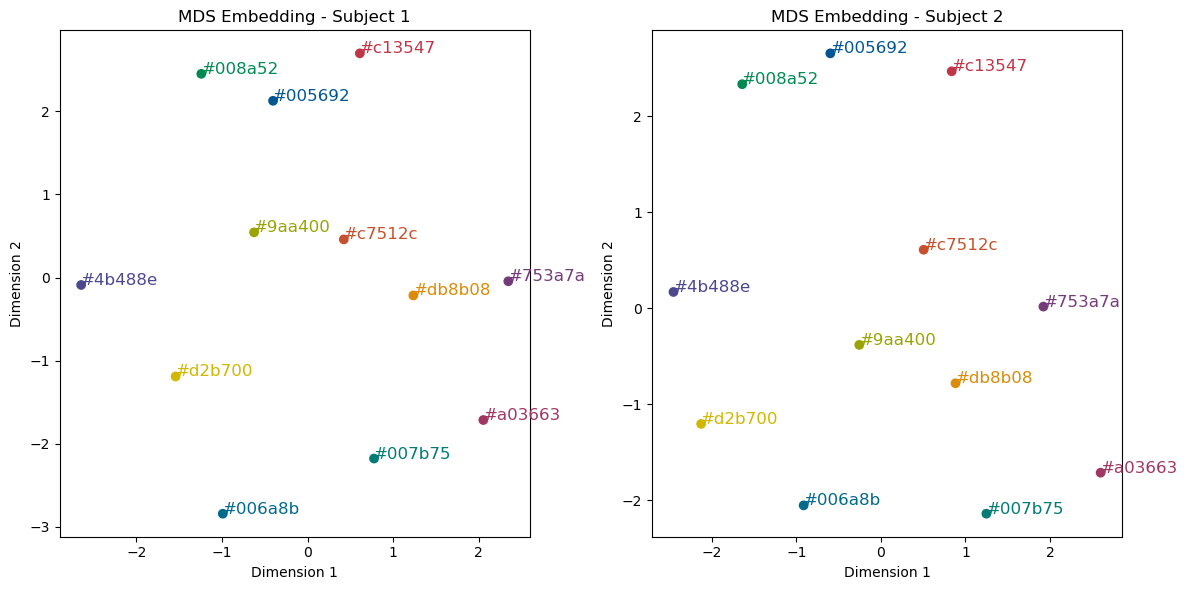

In [72]:
plot_2DMDS(value_mapped_sym_1, value_mapped_sym_2)

### 3D MDS with preference as the z-axis

In [73]:
def plot_3DMDS_overallPreference(matrix_transformed_1, matrix_transformed_2, matrix_transformed_1_as, matrix_transformed_2_as, unique_colours):
    # List to store the embeddings
    embeddings = []

    # First matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
    embedding_2d = mds.fit_transform(matrix_transformed_1)

    # Calculate the average value for each column
    row_averages_1 = matrix_transformed_1_as.mean(axis=0).reshape(-1, 1)

    # Add the row averages as the third dimension
    embedding_3d = np.hstack((embedding_2d, row_averages_1))
    embeddings.append(embedding_3d)

    # Second matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
    embedding_2d = mds.fit_transform(matrix_transformed_2)

    # Calculate the average value for each row
    row_averages_2 = matrix_transformed_2_as.mean(axis=0).reshape(-1, 1)

    # Add the row averages as the third dimension
    embedding_3d = np.hstack((embedding_2d, row_averages_2))
    embeddings.append(embedding_3d)

    plot_3D_embeddings(embeddings, titles=['Subject 1', 'Subject 2'], color_labels=unique_colours, overlay=False)

In [74]:
plot_3DMDS_overallPreference(value_mapped_sym_1, value_mapped_sym_2, value_mapped_raw_1, value_mapped_raw_2, unique_colours)

# GWOT

### GWOT with symmetric matrix (preference distance)

RSA correlation coefficient :  0.16820193551789508


/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



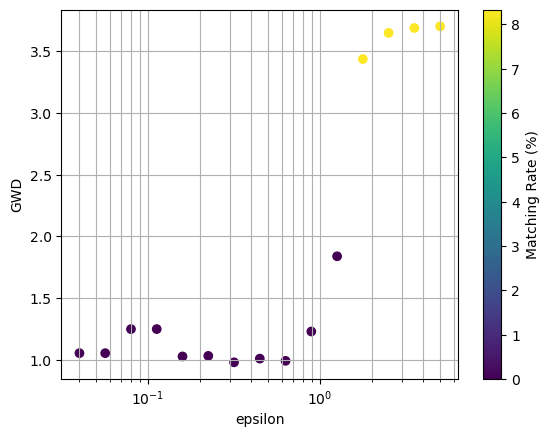

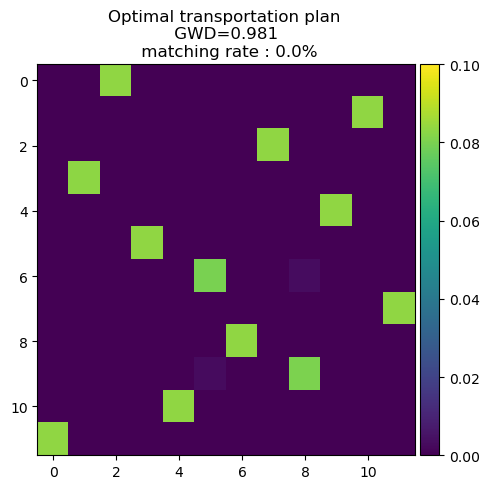

In [75]:
RSA_corr = RSA(value_mapped_sym_1, value_mapped_sym_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_sym, gwds_sym, matching_rates_sym = GWD_and_plot(value_mapped_sym_1, value_mapped_sym_2, epsilons)

In [76]:
embeddings = []
for RDM in [value_mapped_sym_1, value_mapped_sym_2]:
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=5)
    embedding = mds.fit_transform(RDM)
    embeddings.append(embedding)

embeddings_y = embeddings[1]
# barycentric projection of embedding2 to the space of embedding1
projected_embeddings_x = OT_plan_sym @ embeddings_y * len(OT_plan_sym)

plot_3D_embeddings(
    embeddings=[embeddings_y, projected_embeddings_x],
    titles=['Subject 1', 'Subject 2'],
    overlay=False,
    color_labels=unique_colours)

In [77]:
projected_embeddings_x

array([[ 8.52719532e-01,  1.76153263e+00,  2.13683303e+00],
       [-2.39625815e+00, -2.14151291e+00, -4.48701832e-01],
       [ 1.95452563e+00,  5.81922887e-01, -2.54269309e-01],
       [ 9.15797860e-02,  9.15383761e-01, -5.62060997e-02],
       [-2.67919731e-01,  2.39985644e+00,  8.60864266e-01],
       [-1.62156647e+00,  1.48746485e+00, -1.38068124e+00],
       [ 1.30429435e+00, -1.47152849e-01, -1.95430951e+00],
       [ 5.37272571e-01, -2.24745346e-01, -8.36180473e-01],
       [ 1.55257777e+00, -1.14117661e+00, -5.06889013e-02],
       [ 1.16105423e+00, -1.76788815e+00,  2.74583453e-01],
       [-2.13831174e+00, -1.49398482e-03, -1.12382030e-01],
       [-1.03003455e+00, -1.72197651e+00,  1.82147510e+00]])

### GWOT with asymmetric matrix (preference ratings)

RSA correlation coefficient :  -0.3970177769528424


/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



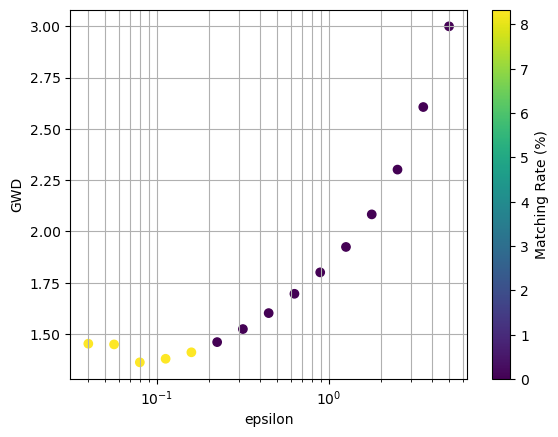

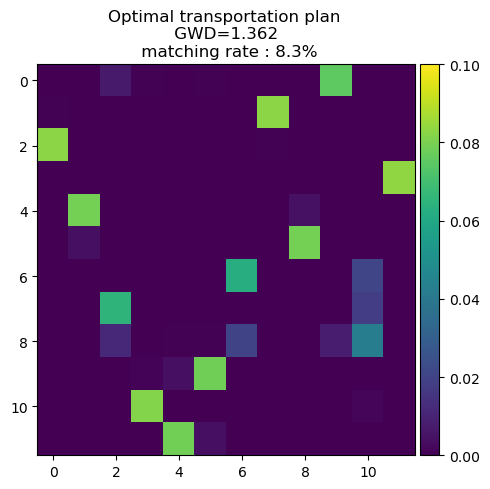

In [78]:
RSA_corr = RSA(value_mapped_raw_1, value_mapped_raw_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_as, gwds_as, matching_rates_as = GWD_and_plot(value_mapped_raw_1, value_mapped_raw_2, epsilons)

### GWOT with random matrix - triangular based

#### Kana

In [79]:
value_mapped_as_shuffledByDiagonal_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  -0.06011450381679399


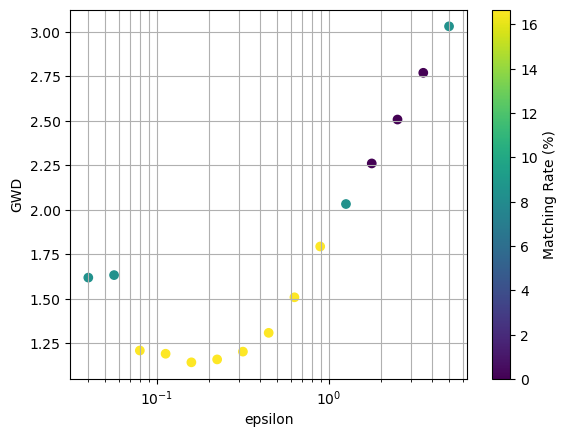

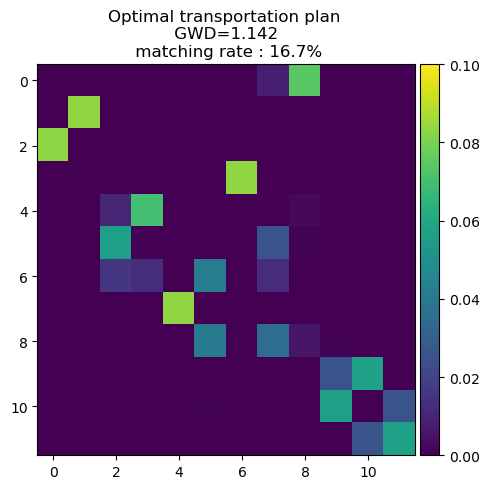

In [80]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_shuffledByDiagonal_1)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledDiagonal_1, gwds_withShuffledDiagonal_1, matching_rates_withShuffledDiagonal_1 = GWD_and_plot(value_mapped_as_1, value_mapped_as_shuffledByDiagonal_1, epsilons)

#### Angus

In [81]:
value_mapped_as_shuffledByDiagonal_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.016783550337656588


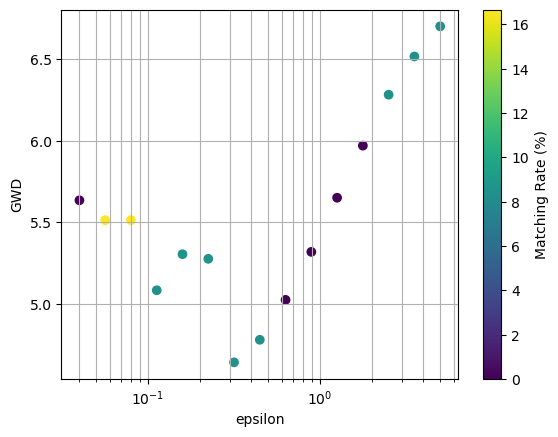

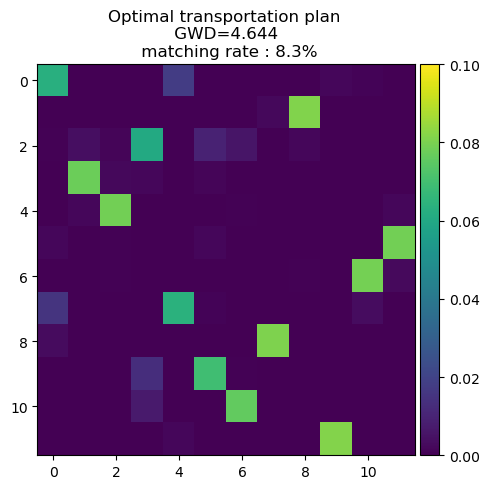

In [82]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_shuffledByDiagonal_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledDiagonal_2, gwds_withShuffledDiagonal_2, matching_rates_withShuffledDiagonal_2 = GWD_and_plot(value_mapped_as_2, value_mapped_as_shuffledByDiagonal_2, epsilons)

### GWOT with random matrix - column based

#### Kana

In [83]:
value_mapped_as_shuffledByColumn_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.4505359548419915


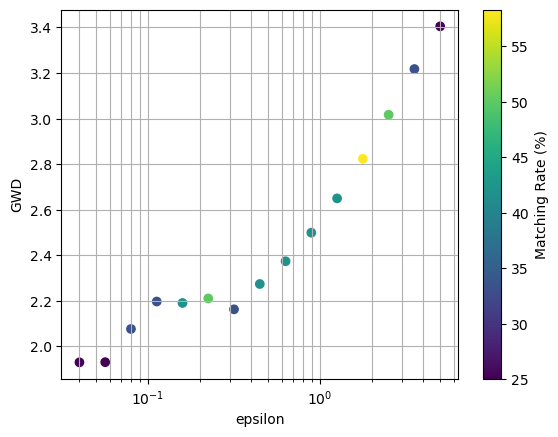

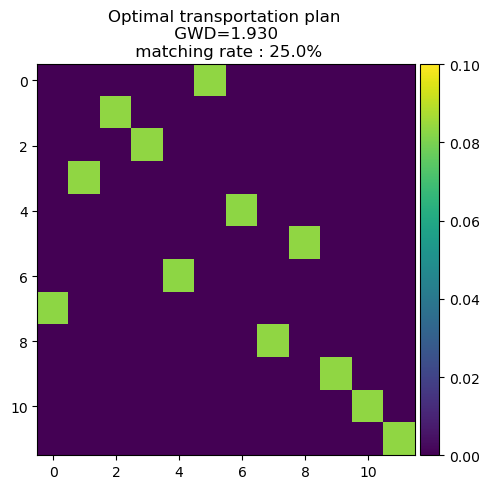

In [84]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_shuffledByColumn_1)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledColumn_1, gwds_withShuffledColumn_1, matching_rates_withShuffledColumn_1 = GWD_and_plot(value_mapped_as_1, value_mapped_as_shuffledByColumn_1, epsilons)

#### Angus

In [85]:
value_mapped_as_shuffledByColumn_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.5767887463347334


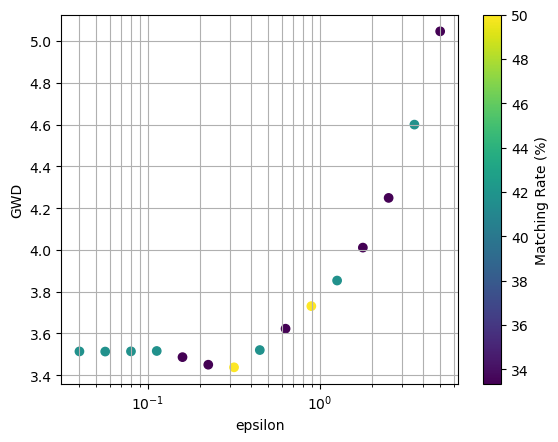

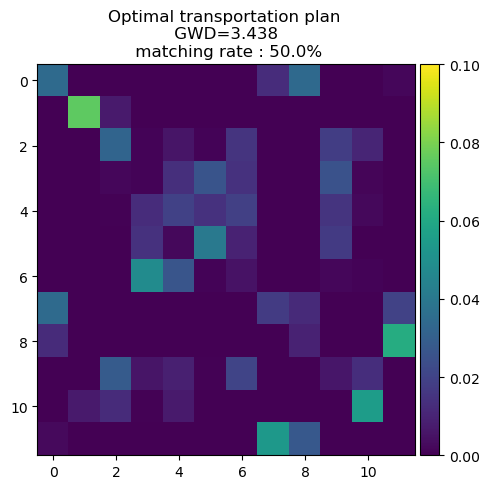

In [86]:
RSA_corr = RSA(value_mapped_as_2, value_mapped_as_shuffledByColumn_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_withShuffledColumn_2, gwds_withShuffledColumn_2, matching_rates_withShuffledColumn_2 = GWD_and_plot(value_mapped_as_2, value_mapped_as_shuffledByColumn_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (diagonal based)

#### Kana

In [87]:
value_mapped_as_shuffledByDiagonal_1_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByDiagonal_1_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.04484732824427485


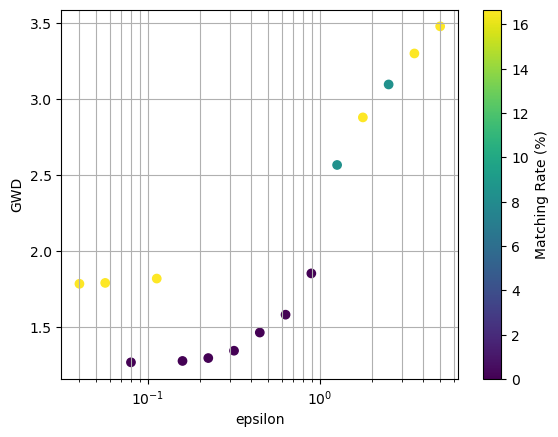

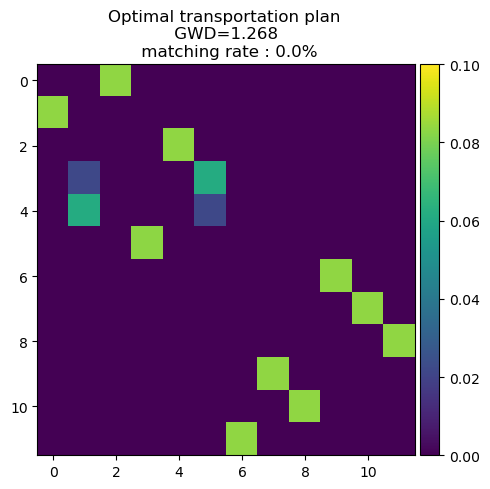

In [88]:
RSA_corr = RSA(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledDiagonal_1, gwds_ShuffledwithShuffledDiagonal_1, matching_rates_ShuffledwithShuffledDiagonal_1 = GWD_and_plot(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2, epsilons)

#### Angus

In [89]:
value_mapped_as_shuffledByDiagonal_2_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByDiagonal_2_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  -0.12361785526238812


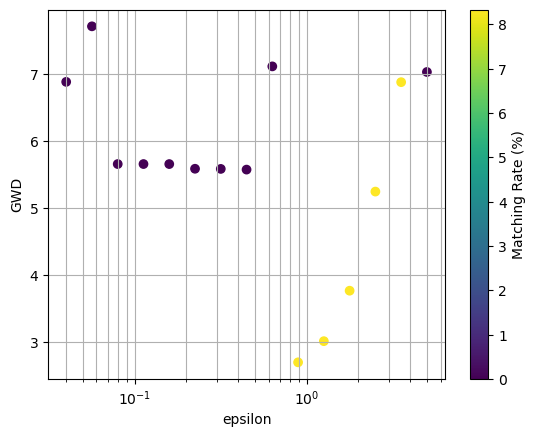

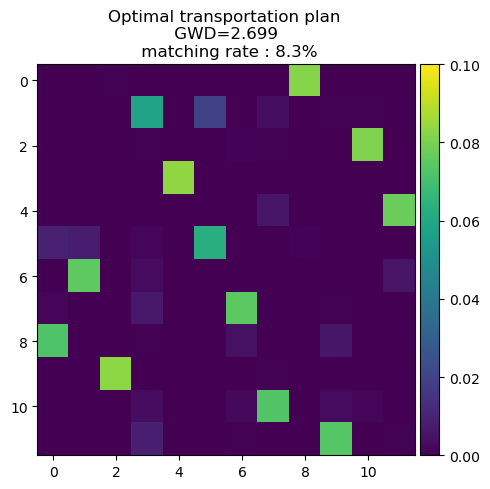

In [90]:
RSA_corr = RSA(value_mapped_as_shuffledByDiagonal_2_1, value_mapped_as_shuffledByDiagonal_2_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledDiagonal_2, gwds_ShuffledwithShuffledDiagonal_2, matching_rates_ShuffledwithShuffledDiagonal_2 = GWD_and_plot(value_mapped_as_shuffledByDiagonal_2_1, value_mapped_as_shuffledByDiagonal_2_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (column based)

#### Kana

In [91]:
value_mapped_as_shuffledByColumn_1_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByColumn_1_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.4153895655382432


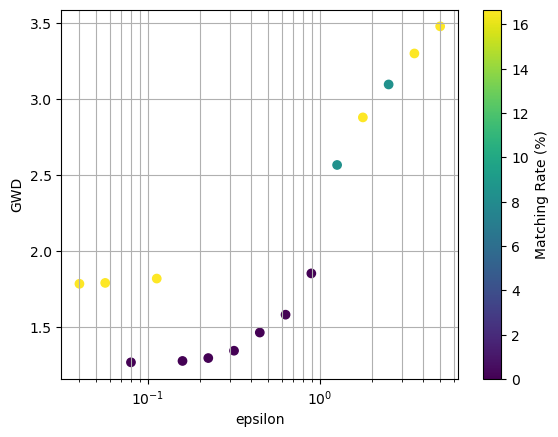

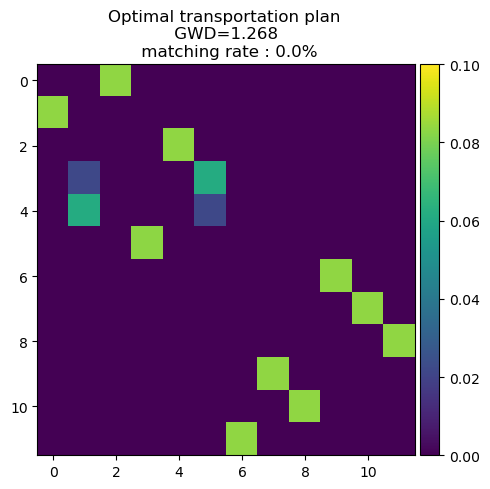

In [92]:
RSA_corr = RSA(value_mapped_as_shuffledByColumn_1_1, value_mapped_as_shuffledByColumn_1_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledColumn_1, gwds_ShuffledwithShuffledColumn_1, matching_rates_ShuffledwithShuffledColumn_1 = GWD_and_plot(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2, epsilons)

#### Angus

In [93]:
value_mapped_as_shuffledByColumn_2_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByColumn_2_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.5053473147013519


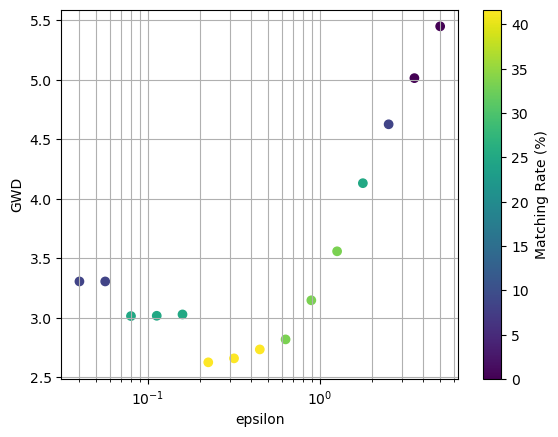

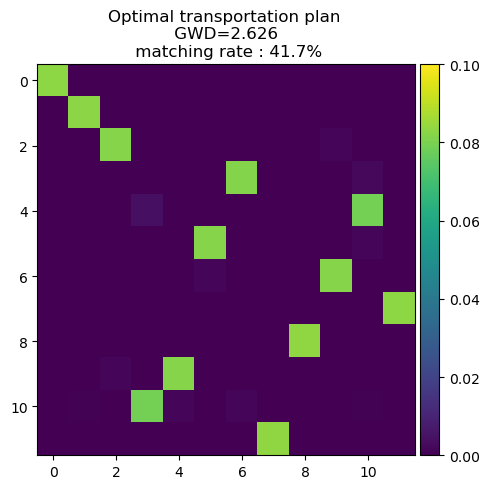

In [94]:
RSA_corr = RSA(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2)
print('RSA correlation coefficient : ', RSA_corr)
OT_plan_ShuffledwithShuffledColumn_2, gwds_ShuffledwithShuffledColumn_2, matching_rates_ShuffledwithShuffledColumn_2 = GWD_and_plot(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2, epsilons)